In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import email
import string
import torch
from bs4 import BeautifulSoup
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import os
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve
import os
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

In [2]:
def set_seed(seed=42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    np.random.seed(seed)

seed = 42
set_seed(seed)

In [3]:
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\Asus Zenbook
[nltk_data]     Flip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Asus Zenbook
[nltk_data]     Flip\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
for filename in os.listdir(os.path.abspath("spam")):
    try:
        with open(os.path.join("spam", filename), "r", encoding="utf-8") as file:
            content = file.read()
    except UnicodeDecodeError:
        with open(os.path.join("spam", filename), "r", encoding="latin-1") as file:
            content = file.read()
        with open(os.path.join("spam", filename), "w", encoding="utf-8") as file:
            file.write(content)
for filename in os.listdir(os.path.abspath("ham")):
    try:
        with open(os.path.join("ham", filename), "r", encoding="utf-8") as file:
            content = file.read()
    except UnicodeDecodeError:
        with open(os.path.join("ham", filename), "r", encoding="latin-1") as file:
            content = file.read()
        with open(os.path.join("ham", filename), "w", encoding="utf-8") as file:
            file.write(content)

In [5]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
class clean_dataset(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None): 
        return self
    def transform(self, X):
        text_list = []
        for mail in X:
            b = email.message_from_string(mail)
            body = ""

            if b.is_multipart():
                for part in b.walk():
                    ctype = part.get_content_type()
                    cdispo = str(part.get('Content-Disposition'))
                    if ctype == 'text/plain' and 'attachment' not in cdispo:
                        body = part.get_payload(decode=True)
            else:
                body = b.get_payload(decode=True)  # récupérer le corp de l'email
            soup = BeautifulSoup(body, "html.parser")
            text = soup.get_text().lower()
             # dollars
            text = text.replace('$', " dollar ")
            text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', 'httpaddr', text, flags=re.MULTILINE)  # remove links
            text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', 'emailaddr', text, flags=re.MULTILINE)  # remove email addresses
            text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
            text = re.sub(r'\d+', 'nombre', text, flags=re.MULTILINE)
            stop_words = stopwords.words('english')
            words_list = [w for w in text.split() if w not in stop_words]  # remove stop words
            words_list = [lemmatizer.lemmatize(w) for w in words_list] 
            words_list = [stemmer.stem(w) for w in words_list]
            text_list.append(' '.join(words_list))
        return np.array(text_list)

In [6]:
spam = []
ham = []

#creation of the spam list
for filename in os.listdir(os.path.abspath("spam")):
    with open(os.path.join("spam", filename), "r", encoding="utf-8") as file_content:
        mail = file_content.read()
        spam.append(mail)

#creation of the ham list
for filename in os.listdir(os.path.abspath("ham")):
    with open(os.path.join("ham", filename), "r", encoding="utf-8") as file_content:
        mail = file_content.read()
        ham.append(mail)

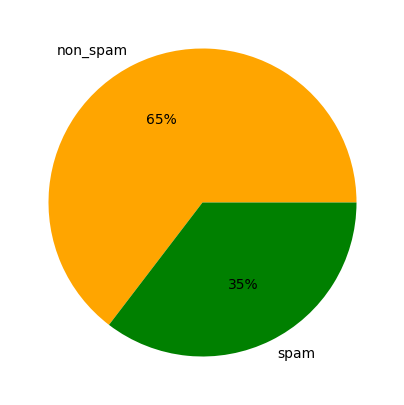

In [7]:
data = [len(ham)/len(ham+spam), len(spam)/len(ham+spam)]
labels = ['non_spam', 'spam']
colors = ['orange', 'green']
plt.figure(figsize=(12, 5))
plt.pie(data, labels = labels, autopct='%.0f%%', colors=colors)
plt.show()

In [8]:
email_to_text = clean_dataset()
text_ham = email_to_text.transform(ham)
text_spam = email_to_text.transform(spam)

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


In [9]:
text_ham = text_ham.tolist()
text_spam = text_spam.tolist()

In [10]:
print(text_ham[0])

date wed nombr aug nombr nombr nombr chri garrigu messageid emailaddr cant reproduc error repeat like everi time without fail debug log pick happen nombr pickit exec pick inbox list lbrace lbrace subject ftp rbrace rbrace nombr sequenc mercuri nombr exec pick inbox list lbrace lbrace subject ftp rbrace rbrace nombr sequenc mercuri nombr ftocpickmsg nombr hit nombr mark nombr hit nombr tkerror syntax error express int note run pick command hand delta dollar pick inbox list lbrace lbrace subject ftp rbrace rbrace nombr sequenc mercuri nombr hit that nombr hit come obvious version nmh im use delta dollar pick version pick nmhnombr compil fuchsiacsmuozau sun mar nombr nombr ict nombr relev part mhprofil delta dollar mhparam pick seq sel list sinc pick command work sequenc actual one that explicit command line search popup one come mhprofil get creat kre p still use version code form day ago havent abl reach cv repositori today local rout issu think exmhwork mail list emailaddr httpaddrwork

In [15]:
text_ham_words = []
for email in text_ham:
    words = email.split()
    text_ham_words.extend(words)

text_spam_words = []
for email in text_spam:
    words = email.split()
    text_spam_words.extend(words)

all_text = text_ham_words+text_spam_words

print(len(all_text))

# Filter the vocabulary to keep only words that appear at least K times in the concatenated list of strings
K = 10

word_counts = Counter(all_text)  # Count occurrences of each word
unique_words = set(all_text)  # Remove duplicate words

print(len(unique_words))

filtered_vocab = [word for word in unique_words if word_counts[word] >= K]
print(len(filtered_vocab))



559582
31090
5101


In [16]:
import json
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(filtered_vocab)
# Save the filtered vocabulary to a JSON file
with open("vocabulaire.json", "w") as outfile:
    json.dump(filtered_vocab, outfile)

In [17]:
X = text_ham+text_spam
print(X[0])

y = len(text_ham)*[0] + len(text_spam)*[1]
print(y)

date wed nombr aug nombr nombr nombr chri garrigu messageid emailaddr cant reproduc error repeat like everi time without fail debug log pick happen nombr pickit exec pick inbox list lbrace lbrace subject ftp rbrace rbrace nombr sequenc mercuri nombr exec pick inbox list lbrace lbrace subject ftp rbrace rbrace nombr sequenc mercuri nombr ftocpickmsg nombr hit nombr mark nombr hit nombr tkerror syntax error express int note run pick command hand delta dollar pick inbox list lbrace lbrace subject ftp rbrace rbrace nombr sequenc mercuri nombr hit that nombr hit come obvious version nmh im use delta dollar pick version pick nmhnombr compil fuchsiacsmuozau sun mar nombr nombr ict nombr relev part mhprofil delta dollar mhparam pick seq sel list sinc pick command work sequenc actual one that explicit command line search popup one come mhprofil get creat kre p still use version code form day ago havent abl reach cv repositori today local rout issu think exmhwork mail list emailaddr httpaddrwork

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = vectorizer.transform(X_train).toarray()
y_train = np.array(y_train).reshape(len(y_train), 1)
X_test = vectorizer.transform(X_test).toarray()
y_test = np.array(y_test).reshape(len(y_test), 1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2763, 5057)
(2763, 1)
(1185, 5057)
(1185, 1)


In [19]:
print("Number of training emails: ", len(X_train))
print("Number of testing emails: ", len(X_test))

Number of training emails:  2763
Number of testing emails:  1185


In [20]:
from sklearn import svm
model = svm.SVC(kernel='linear',C=0.1)
model.fit(X_train,y_train)

SVC(C=0.1, kernel='linear')

In [21]:
predictions=model.predict(X_test)

print("accuracy score = {}%".format(round(accuracy_score(y_test, predictions)*100, 2)))

accuracy score = 97.89%


with threshold = 0.29050567880776934 | test accuracy is 56.13%


Text(0.5, 0, 'False positive rate')

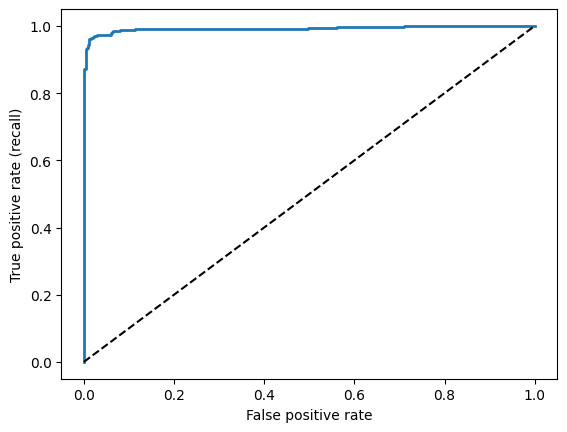

In [ ]:

test_prediction_scores = model.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, test_prediction_scores)

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = thresholds[ix]
test_prediction = np.asarray([ 1 if x > threshold else 0 for x in test_prediction_scores])
print("with threshold = {0} | test accuracy is {1:.2f}%"
      .format(threshold, (test_prediction==np.asarray(y_test)).mean() * 100))

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel("True positive rate (recall)")
plt.xlabel("False positive rate")